# Note to self
I am almost there.... I just need to make sure the `'successor.attr'` will work for function that are dependent on other variables of the river network attribute list...

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx

from dask.distributed import (
    Client,
)

from shapely.geometry import (
    LineString,
    Point,
)

from shapely import (
    union_all,
    ops,
)

import os
import warnings

from typing import (
    Dict,
    TypeAlias,
    Any,
    Optional,
)

from collections.abc import (
    Collection,
    Callable,
)

In [2]:
# MERIT-Basins path
mb_path = '/project/rrg-mclark/data/geospatial-data/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/'

# cat layer
cat = gpd.read_file(os.path.join(mb_path, 'pfaf_level_02', 'cat_pfaf_72_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'))

# riv layer
riv = gpd.read_file(os.path.join(mb_path, 'pfaf_level_02', 'riv_pfaf_72_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'))

# cst layer
cst = gpd.read_file(os.path.join(mb_path, 'coastal_hillslopes', 'hillslope_72_clean.shp'))

In [3]:
def _aggregate_attr(
    rg: nx.DiGraph,
    successor: str | float | int,
    predecessor: float | int | Collection[float | int],
    attr: str,
    method: str | Callable,
    *args: Any,
    **kwargs: Dict[Any, Any],
) -> float | int:
    """Aggregate `attr` values given a `method` of choice that is either
    one of the pre-defined aggregation methods, or a user-defined
    function. If the user-defined function accepts more arguments, they
    can be fed using `args` or `kwargs`.
    
    Parameters
    ----------
    rg : ``networkx.DiGraph``
        A directed acyclic graph of a river network of interest, where
        each node (river confluence) has the same attribute of its outgoing
        edge (river).
    successor : str, float, or int depending on `rg`'s nodes datatypes
        `rg`'s node (river confluence) or its corresponding outgoing edge
        (river segment) which is going to be aggregated and further
        contracted with one or all of its predecessors. Node contraction
        is not done in this method.
    predecessor : str, float, or int depending on `rg`'s nodes datatypes
        `rg`'s node (river confluence) or its corresponding outgoing edge
        (river segment) which is going to be aggregated and further
        contracted with its successor. Node contraction is not done in
        this method.
    attr : str
        Target attribute for aggregation
    method : str or a user-defined function
        Method for aggregation of `attr` values of `successor` and
        `predecessor` nodes. It can be one of the pre-defined methods
        or a user-defined function; in case of a user-defined function,
        if necessary, extra arguments to the `method` function can be
        provided using `*args` or `**kwargs`. A single dictionary of
        all elements of `successor` and `predecessor` is passed to the
        used-defined function.  
        Current pre-defined methods are: 'sum', 'mean', 'min', 'max',
        'upstream', and 'downstream'.
    
    Other Parameters
    ----------------
    agrs: ``any``
        The arguments to be fed to `method`, if a user-defined function
        is provided. Raises ``ValueError`` exception if method is not
        callable.
    kwargs: dict
        The keys of this `dict` are the input arguments to `method`
        if a user-defined function is given; the values must follow the
        datatype of `method`'s arguments'.
    
    Returns
    -------
    dict
        The keys are each of the `predecessor` and values are the
        aggregated `attr` given `sucessor` and `predecessor` values
        based on the user's `method`
    
    Raises
    ------
    ValueError
        If `args` and/or `kwargs` are provided while `method` is not a
        user-defined function.
    TypeError
        If the content of `attr` is not ``float`` or ``int``, then an
        ``TypeError`` is raised
    """
    # if args or kwargs are provided and `method` is not a user-defined
    # function, raise a ValueError exception
    if isinstance(method, str):
        if bool(args) or bool(kwargs):
            raise ValueError("arguments provided through `args` or `kwargs`"
                             " while `method` is not a user-defined"
                             " function")
    # check the data type of `attr`
    if not isinstance(attr, (str, int, float)):
        raise TypeError("`attr` must be of type str, int, or float")
        
    # build attribute dictionary
    attr_dict = nx.get_node_attributes(
        G=rg,
        name=attr,
    )
    
    # build a dictionaries of elements to be aggregated
    successor_dict = {'successor': rg.nodes[successor][attr]}
    predecessor_dict = {'predecessor': rg.nodes[predecessor][attr]}
    
    # create a list of both dictionaries for easier access
    node_dict = {**successor_dict, **predecessor_dict}
    
    # dict value iterator in case all values are needed in one go
    all_attr_values = node_dict.values()
    
    # checking `method`
    # simple summation
    if callable(method):
        return method(**node_dict, **kwargs)
    elif method in ('sum'):
        return sum(all_attr_values)
    # simple average
    elif method in ('mean'):
        return sum(all_attr_values) / len(all_attr_values)
    # minimum value
    elif method in ('min'):
        return min(all_attr_values)
    # maximum value
    elif method in ('max'):
        return max(all_attr_values)
    # get the upstream value given a target upstream
    elif method in ('upstream'):
        return ht.agg_funcs.upstream(
            successor,
            predecessor,
            *args,
            **kwargs,
        )
    # get the downstream value
    elif method in ('downstream'):
        return ht.agg_funcs.downstream(
            successor,
            predecessor,
            *args,
            **kwargs,
        )
    return

In [4]:
def _aggregate_linestring_geoms(
    successor: LineString,
    predecessor: LineString,
) -> LineString:
    """Aggregated (Multi-)LineString geometries for `successor` and
    `predecessor` objects
    
    Parameters
    ----------
    successor: shapely.geometry.LineString
        sucessor LineString to be aggregated
    predecessor: shapely.geometry.LineString
        predecessor LineString to be aggregated with `successor`
    
    Returns
    -------
    shapely.LineString:
        aggregated LineString geometry
    """
    # check if successor and predecessor are shapely.geometry.LineString types
    if not isinstance(successor, LineString):
        raise TypeError("`successor` must be of type shapely.geometry.LineString")
    if not isinstance(predecessor, LineString):
        raise TypeError("`predecessor` must be of type shapely.geometry.LineString")
        
    return ops.linemerge(union_all([successor, predecessor]))

def linestrings_endpoint_distance(
    successor: LineString,
    predecessor: LineString,
    linestring_epsg: Optional[int] = 4326,
    distance_epsg: Optional[int] = 6933,
    *args,
    **kwargs,
) -> float:
    """Calculate the horizontal direct distance between the end points of
    two connected shapely.LineString objects. 
    
    Parameters
    ----------
    successor : shapely.LineString
        The successer river segment that shares a point(s) with the
        `predecessor` object.
    predecessor : shapely.LineString
        The predecessor to `successor` object shareing a common point(s).
    linestring_epsg : int, optional [defaults to `4326`]
        the source EPSG code describing the `crs` of both the `successor` and
        `predecessor` objects. Either `epsg` or `crs` options could be used
        but not both.
    distance_epsg : int, optional [defailts to `6933`]
        the target EPSG code used to calculate the distance between the
        coordinates.
    
    Returns
    -------
    float
        The horizontal distance between the endpoints of two given
        shapely.LineString objects. The unit of the returned value is in
        `meters`, if the `distance_epsg` is set to its default value of
        `6933`.
    
    Raises
    ------
    ValueError
        If `successor` and `predecessor` do not share a common point(s), this
        exception will be raised.
    """
    # check the dtype of `successor` and `predecessor`
    for v in [successor, predecessor]:
        if not isinstance(v, LineString):
            raise ValueError("Two given LineStrings do not touch")

    # check if there is a common point (coordinate) shared between
    # `successor` and `predecessor`
    shared_point = set(successor.coords).intersection(set(predecessor.coords))
    if not shared_point:
        raise ValueError("A common point shared between LineString "
                         "objects is missing")

    # aggregate the geometries of LineString objects
    agg_line = _aggregate_linestring_geoms(successor, predecessor)

    # extract the end points
    end_points = (
        Point(agg_line.coords[0]), 
        Point(agg_line.coords[-1])
    )

    # transform the given `linestring_EPSG` to an equal area 
    # `distance_epsg`
    transformer = Transformer.from_crs(
        linestring_epsg,
        distance_epsg,
        always_xy=True,
    )
    
    # equal-area projection transformed end_points
    transformed_end_points = \
        [Point(transformer.transform(geom.x, geom.y))
             for geom in end_points]

    # calculate distance
    # return end_points
    return _coords_spatial_distance(
        transformed_end_points[0],
        transformed_end_points[1],
    )

def _coords_spatial_distance(
    p1: Point,
    p2: Point,
) -> float:
    """Return the distance between `p1` and `p2`
    
    Parameters
    ----------
    p1 : shapely.Point
        Coordinates of the first point
    p2 : shapely.Point
        Coordinates of the second point
        
    Returns
    -------
    float
        The distance (2D or 3D, depending on Point data) between `p1` and `p2`
    """

    return p1.distance(p2)

In [5]:
def upstream_attr(
    successor: Any,
    predecessor: Any,
    *args,
    **kwargs,
) -> Any:
    """Return the predecessor's attribute
    
    Parameters
    ----------
    successor : Any
        successor attribute value to be ignored
    predecessor : Any
        predecessor attribute value to be returned
    
    Returns
    -------
    predecessor : Any
        attribute value to be returned
    """
    if not predecessor:
        warnings.warn(f"`predecessor` is set to {predecessor}")
    
    return predecessor

In [6]:
def downstream_attr(
    successor: Any,
    predecessor: Any = None,
    *args,
    **kwargs,
) -> Any:
    """Return the predecessor's attribute
    
    Parameters
    ----------
    successor : Any
        successor attribute value to be returned
    predecessor : Any
        predecessor attribute value to be ignored
    
    Returns
    -------
    successor : Any
        attribute value to be returned
    """
    if successor is None:
        warnings.warn("`successor` is set to None")
    
    return successor

In [7]:
def weighted_mean(
    succesor: Any,
    predecessor: Any,
    successor_weight: float,
    predecessor_weight: float,
    *args,
    **kwargs,
) -> Any:
    """Weighted average of `successor` and `predecessor` values given the
    `successor_weight` and `predecessor_weight` weights
    
    Parameters
    ----------
    successor : Any
        successor segment attribute value
    predecessor : Any
        predecessor segment attribute value
    successor_weight : float
        weight for the `successor`
    predecessor_weight : float
        weight for the `predecessor`
    
    Returns
    -------
    float | int
        weighted mean of input arguments
    """
    numerator = (succesor * successor_weight) + (predecessor * predecessor_weight)
    denominator = (successor_weight + predecessor_weight)
    
    return numerator / denominator

In [8]:
def is_int(s):
    try: 
        int(s)
    except ValueError:
        return False
    else:
        return True

In [9]:
def spatial_linestring_agg(
    successor: LineString,
    predecessor: LineString,
) -> LineString:
    """Aggregated (Multi-)LineString geometries for `successor` and
    `predecessor` objects
    
    Parameters
    ----------
    successor: shapely.geometry.LineString
        sucessor LineString to be aggregated
    predecessor: shapely.geometry.LineString
        predecessor LineString to be aggregated with `successor`
    
    Returns
    -------
    shapely.LineString:
        aggregated LineString geometry
    """
    # check if successor and predecessor are shapely.geometry.LineString types
    if not isinstance(successor, LineString):
        raise TypeError("`successor` must be of type shapely.geometry.LineString")
    if not isinstance(predecessor, LineString):
        raise TypeError("`predecessor` must be of type shapely.geometry.LineString")
        
    return ops.linemerge(union_all([successor, predecessor]))

In [10]:
NodeType: TypeAlias = str | int
AttrType: TypeAlias = str

def _aggregate_single_seg(
    rg: nx.DiGraph,
    successor: NodeType,
    predecessor: NodeType,
    attrs: Collection[AttrType] = None,
    attr_agg_funcs: Dict[AttrType, Callable] = None,
    attr_agg_funcs_args : Dict[Callable, Dict[str, Any]] = None,
    inplace = True,
    *args,
    **kwargs,
) -> None:
    """Aggregation of a chosen river segment with an upstream segment.
    
    Parameters
    ----------
    rg : networkx.DiGraph
        A river network in form of a directed acyclic graph (DAG) representing
        connections of river segments. Each graph "vertex" (or "node")
        represents its downstream river segments that is depicted as an "arc".
    successor : str or int, or a collection of the previous data types
        River segment or list of segments to be contracted. In ``hydrant``, a
        river segment is always aggregated with its upstream ones. In case of
        a list of segments, all predecessors (i.e., upstream) segments will be
        used.
    predecessor : str or int, or a collection of the previous data types
        Upstream river segment to be aggregated with the `successor`.
    attrs : list-like object of str, optional
        The attributes to be included in the aggregation process.
    attr_agg_funcs : Callable, optional
        Functions to be applied to the `attrs` elements. If extra arguments
        needed, `agg_funcs_args` dictionary could be used.
    attr_agg_funcs_args : Callable, optional
        Extra arguments to be fed to each of the `attr_agg_funcs` functions
        with keys corresponding to any `attrs_agg_funcs` elements that needs
        extra options.
    inplace : bool, optional [defaults to True]
        If operation is done inplace, nothing is returned, else, the copy of 
        the network including aggregation changes are returned.
    
    Returns
    -------
    networkx.DiGraph
        DAG with `successors` aggregated with its predecessors (upstream
        segments)
    
    Examples
    --------
    The following, creates a sample river network and aggregated the shortest
    river segment with all its upstream reaches
    >>> rg = 
    
    """
    # If operations need to be done "inplace", do not make a copy
    if inplace:
        pass
    else:
        rg = rg.copy()
    
    # FIXME: This should not be different from other attributes
    if 'geometry' in attrs:
        # do geometrical aggregation
        val = attr_agg_funcs['geometry'](
            successor=rg.nodes[successor]['geometry'],
            predecessor=rg.nodes[predecessor]['geometry'],
        )
        nx.set_node_attributes(rg, {predecessor: val}, name='geometry')
        
        # remove from the list-like object
        attrs.remove('geometry')
    
    # aggregate attributes
    for attr in attrs:
        # check if aditional arguments should be provided to the 
        # aggregation function
        if attr in attr_agg_funcs_args:
            args = attr_agg_funcs_args[attr]
        else:
            args = {}
            
        val = _aggregate_attr(
            rg=rg,
            successor=successor,
            predecessor=predecessor,
            attr=attr,
            method=attr_agg_funcs[attr],
            **args
        )
        nx.set_node_attributes(rg, {predecessor: val}, name=attr)
    
    if inplace:
        return
    else:
        return rg

In [11]:
# define the river network
rg = nx.from_pandas_edgelist(
    df=riv,
    source='COMID',
    target='NextDownID',
    edge_attr=riv.columns.to_list(),
    create_using=nx.DiGraph
)
# each river confluence (networkx node) corresponds to its outgoing edge
# (river segment), and all attributes are similar for both objects
nx.set_node_attributes(
    G=rg,
    values=riv.set_index('COMID', drop=False).T.to_dict()
)

# successor
successor = 72051873
# predecessor
predecessor = 72053625

# attribute list
attrs = [
    'lengthkm',
    'uparea',
    'order',
    'geometry',
]

# aggregation functions for each attribute element
attr_agg_funcs = {
    'lengthkm': 'sum',
    'uparea': 'sum',
    'order': upstream_attr,
    'geometry': spatial_linestring_agg,
}

# aggregation functions' extra arguments
attr_agg_funcs_args = {
}

In [12]:
new_rg = _aggregate_single_seg(
    rg=rg,
    successor=successor,
    predecessor=predecessor,
    attrs=attrs,
    attr_agg_funcs=attr_agg_funcs,
    attr_agg_funcs_args=attr_agg_funcs_args,
    inplace=False,
)

<Axes: >

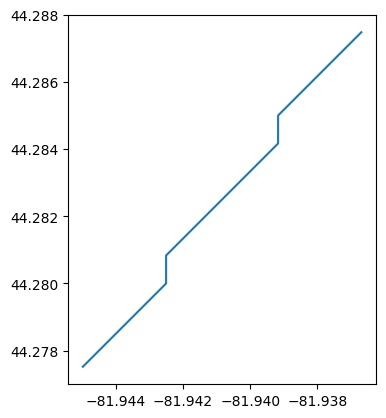

In [13]:
gpd.GeoDataFrame(geometry=[new_rg.nodes[72053625]['geometry']]).plot()

<Axes: >

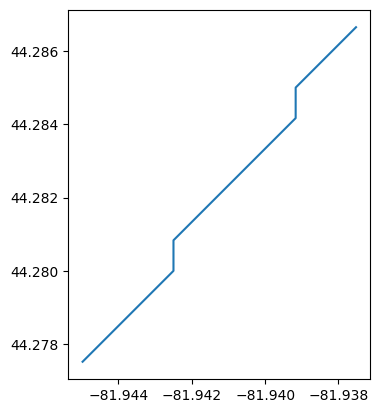

In [14]:
gpd.GeoDataFrame(geometry=[rg.nodes[72053625]['geometry']]).plot()